<a href="https://colab.research.google.com/github/sayanbanerjee32/TASI_ERAv2_S9/blob/main/S9_SayanBanerjee.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import all required packages including local files

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torchsummary import summary

import matplotlib.pyplot as plt

import albumentations as A
from albumentations.pytorch import ToTensorV2

import numpy as np

#import from local modules
from utils import Cifar10Dataset
from utils import train, test, checkpoint, resume
from utils import get_device, plot_accuracy_losses, plot_top_loss
# from models import Net

# Check if GPU available

In [2]:
# CUDA? - call get_device function defined in utils.py
is_cuda, device = get_device()

CUDA Available? True


# Visualising Train data

# Dataset and Creating Train/Test Split

In [3]:
train_data_raw = datasets.CIFAR10('./data', train=True, download=True, transform=transforms.ToTensor())

Files already downloaded and verified


In [4]:
# train data shape
print(train_data_raw.data.shape)
# train data mean
print(train_data_raw.data.mean(axis=(0,1,2))/255)
# train data standard deviation
print(train_data_raw.data.std(axis=(0,1,2))/255)

(50000, 32, 32, 3)
[0.49139968 0.48215841 0.44653091]
[0.24703223 0.24348513 0.26158784]


# Dataloader Arguments & Test/Train Dataloaders

In [5]:
# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if is_cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader_raw = torch.utils.data.DataLoader(train_data_raw, **dataloader_args)

class_labels = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


## Data Visualization

torch.Size([128, 3, 32, 32])
torch.Size([128])


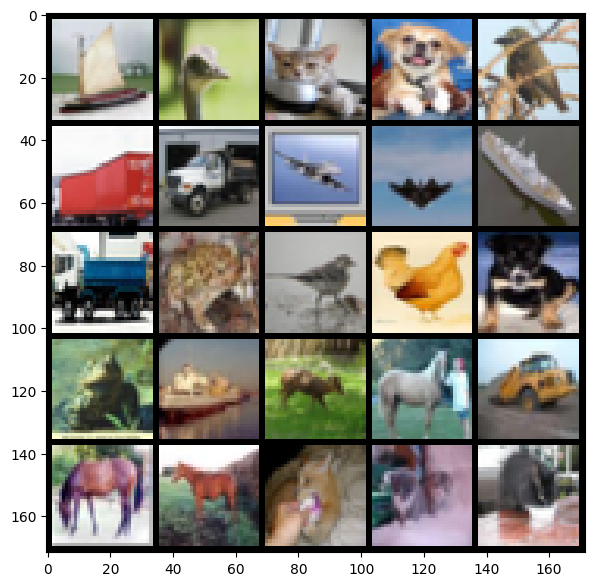

In [6]:
dataiter = iter(train_loader_raw)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

# Create a grid of images
grid = torchvision.utils.make_grid(images[:25], nrow=5)

# Display the grid
plt.figure(figsize=(7,7))
plt.imshow(grid.permute(1,2,0))
plt.show()

In [7]:
# how labels look like
print(' '.join(f'{class_labels[labels[j]]:5s}' for j in range(len(labels[:25]))))

ship  bird  cat   dog   bird  truck truck plane plane ship  truck frog  bird  bird  dog   frog  ship  deer  horse truck horse horse dog   cat   cat  


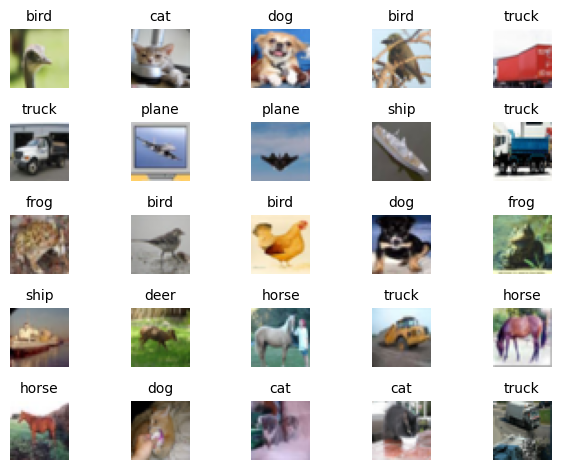

In [8]:
figure = plt.figure()
rows, cols = 5, 5
for index in range(1, cols * rows  + 1):
    plt.subplot(rows, cols, index)
    plt.title(class_labels[labels[index]],fontsize = 10)
    plt.axis('off')
    plt.imshow(images[index].permute(1, 2, 0))
figure.tight_layout()
plt.show()

# Train and Test transformations

In [9]:
# class Cifar10Dataset(datasets.CIFAR10):
#     def __init__(self, root = './data', train=True, download=True, transform=None):
#         super().__init__(root=root, train=train, download=download, transform=transform)

#     def __getitem__(self, index):
#         image, label = self.data[index], self.targets[index]

#         if self.transform is not None:
#             transformed = self.transform(image=image)
#             image = transformed["image"]

#         return image, label

In [10]:
# Train Phase transformations
train_transforms = A.Compose([
                                A.HorizontalFlip(p=0.5),
                                A.ShiftScaleRotate(shift_limit=0.8, scale_limit=1.4, rotate_limit=360, p=0.5),
                                A.Normalize((0.4914,0.4822,0.4465), (0.247,0.243,0.262)),
                                A.CoarseDropout(max_holes = 1, max_height=16, max_width=16, min_holes = 1, min_height=16, min_width=16,
                                                fill_value=[0.4914,0.4822,0.4465], mask_fill_value = None),
                                ToTensorV2(),
                                ])

# Test Phase transformations
test_transforms = A.Compose([
                            A.Normalize((0.4914,0.4822,0.4465), (0.247,0.243,0.262)),
                            ToTensorV2(),
                            ])

# Dataset and Creating Train/Test Split

In [11]:
# train_data = datasets.CIFAR10('./data', train=True, download=True, transform=train_transforms)
# test_data = datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)
train_data = Cifar10Dataset(transform=train_transforms)
test_data = Cifar10Dataset(train=False, transform=test_transforms)

Files already downloaded and verified
Files already downloaded and verified


In [12]:
train_data

Dataset Cifar10Dataset
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose([
             HorizontalFlip(always_apply=False, p=0.5),
             ShiftScaleRotate(always_apply=False, p=0.5, shift_limit_x=(-0.8, 0.8), shift_limit_y=(-0.8, 0.8), scale_limit=(-1.4, 1.4), rotate_limit=(-360, 360), interpolation=1, border_mode=4, value=None, mask_value=None, rotate_method='largest_box'),
             Normalize(always_apply=False, p=1.0, mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.243, 0.262), max_pixel_value=255.0),
             CoarseDropout(always_apply=False, p=0.5, max_holes=1, max_height=16, max_width=16, min_holes=1, min_height=16, min_width=16, fill_value=[0.4914, 0.4822, 0.4465], mask_fill_value=None),
             ToTensorV2(always_apply=True, p=1.0, transpose_mask=False),
           ], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={}, is_check_shapes=True)

# Dataloader Arguments & Test/Train Dataloaders

In [13]:
# train dataloader
train_loader = torch.utils.data.DataLoader(train_data, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test_data, **dataloader_args)

### Augmented data visualization

torch.Size([128, 3, 32, 32])
torch.Size([128])


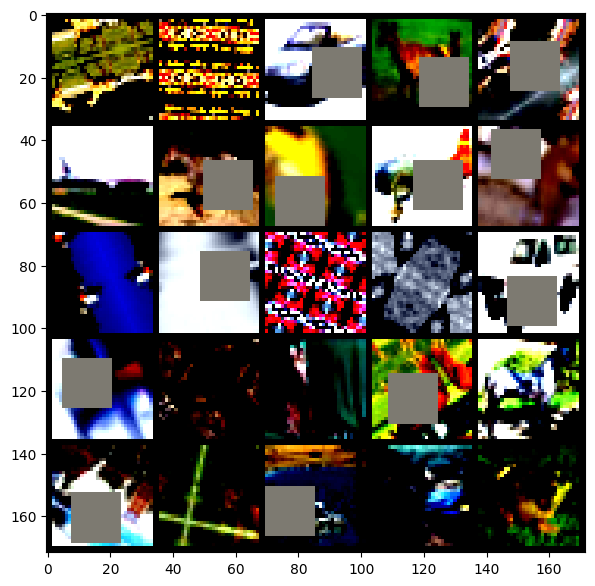

In [14]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

# Create a grid of images
grid = torchvision.utils.make_grid(images[:25], nrow=5)

# Display the grid
plt.figure(figsize=(7,7))
plt.imshow(grid.permute(1,2,0))
plt.show()

# Training

In [15]:
class Net(nn.Module):
    def __init__(self, dropout_value = 0.1):
        super(Net, self).__init__()
        # # Input Block / CONVOLUTION BLOCK 1
        self.C1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32,
                      kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value)
        ) #input size: 32 x 32 x 3, output size: 32 x 32 x 32, receptive field: 1 + (3-1) * 1 = 3


        self.C2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64,
                      kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value)
        ) #input size: 32 x 32 x 32, output size: 32 x 32 x 64, receptive field: 3 + (3-1) * 1 = 5

        # ## Strided convolution
        # self.SC1 = nn.Sequential(
        #     nn.Conv2d(in_channels=64, out_channels=64,
        #               kernel_size=(3, 3), padding=1, stride = 2, bias=False),
        #     nn.ReLU(),
        #     nn.BatchNorm2d(64),
        #     nn.Dropout(dropout_value)
        # ) #input size: 32 x 32 x n*2, output size: 24 x 24 x n*4, receptive field: 3 + (3-1) * 1 = 5
        # #Lout =  (Lin + 2 * padding - dilation * (kernel - 1) - 1) / stride + 1
        # # ((32 + 2 * 1 - 1 * (3 - 1) -1) / 2) + 1 = 16

        ## dilated convolution
        self.SC1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64,
                      kernel_size=(3, 3), padding=1, dilation = 8, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value)
        ) #input size: 32 x 32 x n*2, output size: 24 x 24 x n*4, receptive field: 3 + (3-1) * 1 = 5
        # ((32 + 2 * 1 - 8 * (3 - 1) -1) / 1) + 1 = 25

        # TRANSITION BLOCK 1
        self.t1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=32,
                      kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value)
        ) #input size: 17 x 17 x n*4, output size: 17 x 17 x n, receptive field: 6 + (1-1)*2 = 6


        # CONVOLUTION BLOCK 2
        self.C3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64,
                      kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value)
        ) #input size: 16 x 16 x n, output size: 16 x 16 x n*2, receptive field: 6 + (3-1) * 2 = 10

        self.C4 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128,
                      kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Dropout(dropout_value)
        ) #input size: 16 x 16 x n*2, output size: 16 x 16 x n*4, receptive field: 10 + (3-1) * 2 = 14

        # self.SC2 = nn.Sequential(
        #     nn.Conv2d(in_channels=128, out_channels=128,
        #               kernel_size=(3, 3), padding=1, stride = 2, bias=False),
        #     nn.ReLU(),
        #     nn.BatchNorm2d(128),
        #     nn.Dropout(dropout_value)
        # ) #input size: 16 x 16 x n*4, output size: 16 x 16 x n*4, receptive field: 14 + (3-1) * 2 = 18

        self.SC2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128,
                      kernel_size=(3, 3), padding=1, dilation = 4, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Dropout(dropout_value)
        ) #input size: 16 x 16 x n*4, output size: 16 x 16 x n*4, receptive field: 14 + (3-1) * 2 = 18
        # ((18 + 2 * 1 - 4 * (3 - 1) -1) / 1) + 1 = 12
        # TRANSITION BLOCK 2
        self.t2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=32,
                      kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value)
        ) #input size: 16 x 16 x n*4, output size: 16 x 16 x n, receptive field: 18 + (1-1)*2 = 18

        # CONVOLUTION BLOCK 3
        # self.C5 = nn.Sequential(
        #     nn.Conv2d(in_channels=32, out_channels=64,
        #               kernel_size=(3, 3), padding=1, bias=False),
        #     nn.ReLU(),
        #     nn.BatchNorm2d(64),
        #     nn.Dropout(dropout_value)
        # ) #input size: 16 x 16 x n, output size: 16 x 16 x n*2, receptive field: 6 + (3-1) * 2 = 10

        # self.C6 = nn.Sequential(
        #     nn.Conv2d(in_channels=64, out_channels=128,
        #               kernel_size=(3, 3), padding=1, bias=False),
        #     nn.ReLU(),
        #     nn.BatchNorm2d(128),
        #     nn.Dropout(dropout_value)
        # ) #input size: 16 x 16 x n*2, output size: 16 x 16 x n*4, receptive field: 10 + (3-1) * 2 = 14
        self.C5 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, groups = 32,
                      kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value)
        ) #input size: 16 x 16 x n, output size: 16 x 16 x n*2, receptive field: 6 + (3-1) * 2 = 10

        self.C6 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, groups = 64,
                      kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Dropout(dropout_value)
        ) #input size: 16 x 16 x n*2, output size: 16 x 16 x n*4, receptive field: 10 + (3-1) * 2 = 14

        # self.SC3 = nn.Sequential(
        #     nn.Conv2d(in_channels=128, out_channels=128,
        #               kernel_size=(3, 3), padding=1, stride = 2, bias=False),
        #     nn.ReLU(),
        #     nn.BatchNorm2d(128),
        #     nn.Dropout(dropout_value)
        # ) #input size: 16 x 16 x n*4, output size: 16 x 16 x n*4, receptive field: 14 + (3-1) * 2 = 18
        self.SC3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128,
                      kernel_size=(3, 3), padding=1, dilation = 2, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Dropout(dropout_value)
        ) #input size: 16 x 16 x n*4, output size: 16 x 16 x n*4, receptive field: 14 + (3-1) * 2 = 18
        # ((12 + 2 * 1 - 4 * (3 - 1) -1) / 1) + 1 = 11
        # TRANSITION BLOCK 3
        self.t3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=32,
                      kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value)
        ) #input size: 16 x 16 x n*4, output size: 16 x 16 x n, receptive field: 18 + (1-1)*2 = 18

        # CONVOLUTION BLOCK 4
        # self.C7 = nn.Sequential(
        #     nn.Conv2d(in_channels=32, out_channels=64,
        #               kernel_size=(3, 3), padding=1, bias=False),
        #     nn.ReLU(),
        #     nn.BatchNorm2d(64),
        #     nn.Dropout(dropout_value)
        # ) #input size: 8 x 8 x n, output size: 8 x 8 x n*2, receptive field: 20 + (3-1) * 4 = 28

        # self.C8 = nn.Sequential(
        #     nn.Conv2d(in_channels=64, out_channels=128,
        #               kernel_size=(3, 3), padding=1, bias=False),
        #     nn.ReLU(),
        #     nn.BatchNorm2d(128),
        #     nn.Dropout(dropout_value)
        # ) #input size: 8 x 8 x n*2, output size: 8 x 8 x n*4, receptive field: 28 + (3-1) * 4 = 36

        self.C7 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, groups = 32,
                      kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value)
        ) #input size: 8 x 8 x n, output size: 8 x 8 x n*2, receptive field: 20 + (3-1) * 4 = 28

        self.C8 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, groups = 64,
                      kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Dropout(dropout_value)
        ) #input size: 8 x 8 x n*2, output size: 8 x 8 x n*4, receptive field: 28 + (3-1) * 4 = 36

        # self.C10 = nn.Sequential(
        #     nn.Conv2d(in_channels=n*4, out_channels=n*4,
        #               kernel_size=(3, 3), padding=1, bias=False),
        #     nn.ReLU(),
        #     nn.BatchNorm2d(n*4),
        #     nn.Dropout(dropout_value)
        # ) #input size: 8 x 8 x n*4, output size: 8 x 8 x n*4, receptive field: 36 + (3-1) * 4 = 44

        # OUTPUT BLOCK
        self.GAP = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1))
        ) #input size: 8 x 8 x n*4, output size: 1 x 1 x n*4, receptive field: 44

        self.c11 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=10,
                      kernel_size=(1, 1), padding=0, bias=False),
        ) #input size: 1 x 1 x n*4, output size: 1 x 1 x 10, receptive field: 44 + (1-1) * 4 =44



    def forward(self, x):
        x = self.C1(x)
        x = self.C2(x)

        x = self.SC1(x)
        x = self.t1(x)

        x = self.C3(x)
        x = self.C4(x)

        x = self.SC2(x)
        x = self.t2(x)

        x = self.C5(x)
        x = self.C6(x)

        x = self.SC3(x)
        x = self.t3(x)

        x = self.C7(x)
        x = self.C8(x)

        x = self.GAP(x)
        x = self.c11(x)

        x = x.squeeze()

        return F.log_softmax(x, dim=-1)

In [16]:
# visualise model parameters
model = Net().to(device)
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
              ReLU-2           [-1, 32, 32, 32]               0
       BatchNorm2d-3           [-1, 32, 32, 32]              64
           Dropout-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]          18,432
              ReLU-6           [-1, 64, 32, 32]               0
       BatchNorm2d-7           [-1, 64, 32, 32]             128
           Dropout-8           [-1, 64, 32, 32]               0
            Conv2d-9           [-1, 64, 18, 18]          36,864
             ReLU-10           [-1, 64, 18, 18]               0
      BatchNorm2d-11           [-1, 64, 18, 18]             128
          Dropout-12           [-1, 64, 18, 18]               0
           Conv2d-13           [-1, 32, 18, 18]           2,048
             ReLU-14           [-1, 32,

strided - 641,248 - 51% - 74%  
Dilated - 641,248 - 47% - 68%

Depthwise - 460,384 - 49% - 71%

In [17]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

In [18]:
# def checkpoint(model, filename):
#     torch.save(model.state_dict(), filename)

# def resume(model, filename):
#     model.load_state_dict(torch.load(filename))

In [19]:
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer  = optimizer,
                                                 mode = 'min',
                                                 factor = 0.1,
                                                 min_lr = 0.0001,
                                                 threshold_mode  = 'rel',
                                                 threshold = 0.0001,
                                                 patience  = 2,
                                                 verbose = True)
criterion = F.nll_loss
num_epochs = 50
early_stopping_patience = 5
best_test_loss = np.inf
best_epoch = -1
for epoch in range(1, num_epochs+1):
    print(f'Epoch {epoch}')
    # call train function from utils.py
    trn_acc, trn_loss = train(model, device, train_loader, optimizer, criterion)
    # accumulate train accuracies and test losses for visualisation
    train_acc.append(trn_acc)
    train_losses.append(trn_loss)

    # call test function from utils.py
    tst_acc, tst_loss = test(model, device, test_loader, criterion)
    # accumulate test accuracies and test losses for visualisation
    test_acc.append(tst_acc)
    test_losses.append(tst_loss)

    scheduler.step(tst_loss)
    # early stopping
    if tst_loss < best_test_loss:
        best_test_loss = tst_loss
        best_epoch = epoch
        checkpoint(model, "best_model.pth")
    elif epoch - best_epoch > early_stopping_patience:
        print("Early stopped training at epoch %d" % epoch)
        break  # terminate the training loop

resume(model, "best_model.pth")

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1


Train: Loss=1.7278 Batch_id=390 Accuracy=26.19: 100%|██████████| 391/391 [00:22<00:00, 17.57it/s]


Test set: Average loss: 1.6753, Accuracy: 3681/10000 (36.81%)

Epoch 2


Train: Loss=1.8356 Batch_id=390 Accuracy=31.49: 100%|██████████| 391/391 [00:17<00:00, 22.26it/s]


Test set: Average loss: 1.5572, Accuracy: 4264/10000 (42.64%)

Epoch 3


Train: Loss=1.6829 Batch_id=390 Accuracy=33.66: 100%|██████████| 391/391 [00:17<00:00, 22.37it/s]


Test set: Average loss: 1.5364, Accuracy: 4418/10000 (44.18%)

Epoch 4


Train: Loss=1.5616 Batch_id=390 Accuracy=36.00: 100%|██████████| 391/391 [00:17<00:00, 22.12it/s]


Test set: Average loss: 1.3541, Accuracy: 5289/10000 (52.89%)

Epoch 5


Train: Loss=1.6072 Batch_id=390 Accuracy=37.55: 100%|██████████| 391/391 [00:18<00:00, 21.66it/s]


Test set: Average loss: 1.2963, Accuracy: 5349/10000 (53.49%)

Epoch 6


Train: Loss=1.6312 Batch_id=390 Accuracy=39.58: 100%|██████████| 391/391 [00:18<00:00, 21.38it/s]


Test set: Average loss: 1.1716, Accuracy: 5948/10000 (59.48%)

Epoch 7


Train: Loss=1.7123 Batch_id=390 Accuracy=40.71: 100%|██████████| 391/391 [00:18<00:00, 21.00it/s]


Test set: Average loss: 1.1441, Accuracy: 6049/10000 (60.49%)

Epoch 8


Train: Loss=1.4464 Batch_id=390 Accuracy=42.33: 100%|██████████| 391/391 [00:17<00:00, 21.98it/s]


Test set: Average loss: 1.1326, Accuracy: 6033/10000 (60.33%)

Epoch 9


Train: Loss=1.7385 Batch_id=390 Accuracy=42.82: 100%|██████████| 391/391 [00:18<00:00, 21.42it/s]


Test set: Average loss: 1.0614, Accuracy: 6321/10000 (63.21%)

Epoch 10


Train: Loss=1.3675 Batch_id=390 Accuracy=43.86: 100%|██████████| 391/391 [00:17<00:00, 22.17it/s]


Test set: Average loss: 0.9775, Accuracy: 6615/10000 (66.15%)

Epoch 11


Train: Loss=1.5196 Batch_id=390 Accuracy=44.81: 100%|██████████| 391/391 [00:18<00:00, 21.29it/s]


Test set: Average loss: 0.9882, Accuracy: 6586/10000 (65.86%)

Epoch 12


Train: Loss=1.5173 Batch_id=390 Accuracy=45.50: 100%|██████████| 391/391 [00:17<00:00, 22.07it/s]


Test set: Average loss: 1.0046, Accuracy: 6592/10000 (65.92%)

Epoch 13


Train: Loss=1.2465 Batch_id=390 Accuracy=45.95: 100%|██████████| 391/391 [00:18<00:00, 20.95it/s]


Test set: Average loss: 0.9574, Accuracy: 6732/10000 (67.32%)

Epoch 14


Train: Loss=1.2052 Batch_id=390 Accuracy=46.65: 100%|██████████| 391/391 [00:17<00:00, 21.98it/s]


Test set: Average loss: 0.9515, Accuracy: 6711/10000 (67.11%)

Epoch 15


Train: Loss=1.5702 Batch_id=390 Accuracy=47.07: 100%|██████████| 391/391 [00:18<00:00, 21.36it/s]


Test set: Average loss: 0.9500, Accuracy: 6811/10000 (68.11%)

Epoch 16


Train: Loss=1.6896 Batch_id=390 Accuracy=47.62: 100%|██████████| 391/391 [00:18<00:00, 21.58it/s]


Test set: Average loss: 0.9100, Accuracy: 6801/10000 (68.01%)

Epoch 17


Train: Loss=1.2913 Batch_id=390 Accuracy=47.74: 100%|██████████| 391/391 [00:18<00:00, 21.17it/s]


Test set: Average loss: 0.9085, Accuracy: 6980/10000 (69.80%)

Epoch 18


Train: Loss=1.1811 Batch_id=390 Accuracy=48.18: 100%|██████████| 391/391 [00:17<00:00, 21.99it/s]


Test set: Average loss: 0.8801, Accuracy: 6983/10000 (69.83%)

Epoch 19


Train: Loss=1.4319 Batch_id=390 Accuracy=48.46: 100%|██████████| 391/391 [00:18<00:00, 21.10it/s]


Test set: Average loss: 0.8435, Accuracy: 7129/10000 (71.29%)

Epoch 20


Train: Loss=1.6991 Batch_id=390 Accuracy=49.01: 100%|██████████| 391/391 [00:17<00:00, 21.96it/s]


Test set: Average loss: 0.8223, Accuracy: 7174/10000 (71.74%)

Epoch 21


Train: Loss=1.4019 Batch_id=390 Accuracy=49.39: 100%|██████████| 391/391 [00:18<00:00, 21.16it/s]


Test set: Average loss: 0.8145, Accuracy: 7225/10000 (72.25%)

Epoch 22


Train: Loss=1.4521 Batch_id=390 Accuracy=49.37: 100%|██████████| 391/391 [00:17<00:00, 21.96it/s]


Test set: Average loss: 0.8427, Accuracy: 7149/10000 (71.49%)

Epoch 23


Train: Loss=1.5172 Batch_id=390 Accuracy=50.09: 100%|██████████| 391/391 [00:18<00:00, 21.17it/s]


Test set: Average loss: 0.8227, Accuracy: 7270/10000 (72.70%)

Epoch 24


Train: Loss=1.2397 Batch_id=390 Accuracy=50.35: 100%|██████████| 391/391 [00:17<00:00, 21.96it/s]


Test set: Average loss: 0.8131, Accuracy: 7297/10000 (72.97%)

Epoch 25


Train: Loss=1.5077 Batch_id=390 Accuracy=50.35: 100%|██████████| 391/391 [00:19<00:00, 20.25it/s]


Test set: Average loss: 0.8129, Accuracy: 7185/10000 (71.85%)

Epoch 26


Train: Loss=1.2772 Batch_id=390 Accuracy=50.67: 100%|██████████| 391/391 [00:17<00:00, 22.03it/s]


Test set: Average loss: 0.8610, Accuracy: 7078/10000 (70.78%)

Epoch 27


Train: Loss=1.4044 Batch_id=390 Accuracy=50.79: 100%|██████████| 391/391 [00:18<00:00, 21.21it/s]


Test set: Average loss: 0.7627, Accuracy: 7406/10000 (74.06%)

Epoch 28


Train: Loss=1.4687 Batch_id=390 Accuracy=50.86: 100%|██████████| 391/391 [00:17<00:00, 21.91it/s]


Test set: Average loss: 0.7970, Accuracy: 7308/10000 (73.08%)

Epoch 29


Train: Loss=1.2503 Batch_id=390 Accuracy=51.10: 100%|██████████| 391/391 [00:18<00:00, 21.25it/s]


Test set: Average loss: 0.7852, Accuracy: 7345/10000 (73.45%)

Epoch 30


Train: Loss=1.2989 Batch_id=390 Accuracy=51.27: 100%|██████████| 391/391 [00:17<00:00, 21.97it/s]


Test set: Average loss: 0.7818, Accuracy: 7374/10000 (73.74%)

Epoch 31


Train: Loss=1.2684 Batch_id=390 Accuracy=53.20: 100%|██████████| 391/391 [00:18<00:00, 21.11it/s]


Test set: Average loss: 0.6935, Accuracy: 7678/10000 (76.78%)

Epoch 32


Train: Loss=1.3788 Batch_id=390 Accuracy=53.52: 100%|██████████| 391/391 [00:17<00:00, 22.04it/s]


Test set: Average loss: 0.6910, Accuracy: 7667/10000 (76.67%)

Epoch 33


Train: Loss=1.4241 Batch_id=390 Accuracy=54.09: 100%|██████████| 391/391 [00:18<00:00, 21.07it/s]


Test set: Average loss: 0.6884, Accuracy: 7645/10000 (76.45%)

Epoch 34


Train: Loss=1.2238 Batch_id=390 Accuracy=54.70: 100%|██████████| 391/391 [00:18<00:00, 21.15it/s]


Test set: Average loss: 0.6803, Accuracy: 7694/10000 (76.94%)

Epoch 35


Train: Loss=1.5569 Batch_id=390 Accuracy=54.46: 100%|██████████| 391/391 [00:18<00:00, 21.46it/s]


Test set: Average loss: 0.6756, Accuracy: 7666/10000 (76.66%)

Epoch 36


Train: Loss=1.4853 Batch_id=390 Accuracy=54.42: 100%|██████████| 391/391 [00:17<00:00, 21.82it/s]


Test set: Average loss: 0.6693, Accuracy: 7704/10000 (77.04%)

Epoch 37


Train: Loss=1.1885 Batch_id=390 Accuracy=54.85: 100%|██████████| 391/391 [00:17<00:00, 21.84it/s]


Test set: Average loss: 0.6684, Accuracy: 7703/10000 (77.03%)

Epoch 38


Train: Loss=1.4459 Batch_id=390 Accuracy=54.60: 100%|██████████| 391/391 [00:18<00:00, 21.67it/s]


Test set: Average loss: 0.6748, Accuracy: 7685/10000 (76.85%)

Epoch 39


Train: Loss=1.3569 Batch_id=390 Accuracy=54.89: 100%|██████████| 391/391 [00:17<00:00, 21.97it/s]


Test set: Average loss: 0.6724, Accuracy: 7692/10000 (76.92%)

Epoch 40


Train: Loss=1.3149 Batch_id=390 Accuracy=54.99: 100%|██████████| 391/391 [00:18<00:00, 21.36it/s]


Test set: Average loss: 0.6654, Accuracy: 7728/10000 (77.28%)

Epoch 41


Train: Loss=1.1637 Batch_id=390 Accuracy=54.74: 100%|██████████| 391/391 [00:17<00:00, 21.99it/s]


Test set: Average loss: 0.6662, Accuracy: 7702/10000 (77.02%)

Epoch 42


Train: Loss=1.2597 Batch_id=390 Accuracy=54.69: 100%|██████████| 391/391 [00:18<00:00, 21.41it/s]


Test set: Average loss: 0.6633, Accuracy: 7694/10000 (76.94%)

Epoch 43


Train: Loss=1.3844 Batch_id=390 Accuracy=55.23: 100%|██████████| 391/391 [00:17<00:00, 21.84it/s]


Test set: Average loss: 0.6651, Accuracy: 7740/10000 (77.40%)

Epoch 44


Train: Loss=1.1446 Batch_id=390 Accuracy=54.53: 100%|██████████| 391/391 [00:19<00:00, 20.45it/s]


Test set: Average loss: 0.6642, Accuracy: 7733/10000 (77.33%)

Epoch 45


Train: Loss=1.1659 Batch_id=390 Accuracy=55.09: 100%|██████████| 391/391 [00:17<00:00, 21.75it/s]


Test set: Average loss: 0.6653, Accuracy: 7739/10000 (77.39%)

Epoch 46


Train: Loss=1.4161 Batch_id=390 Accuracy=55.26: 100%|██████████| 391/391 [00:18<00:00, 21.05it/s]


Test set: Average loss: 0.6561, Accuracy: 7748/10000 (77.48%)

Epoch 47


Train: Loss=1.2620 Batch_id=390 Accuracy=55.17: 100%|██████████| 391/391 [00:17<00:00, 21.86it/s]


Test set: Average loss: 0.6514, Accuracy: 7751/10000 (77.51%)

Epoch 48


Train: Loss=1.1237 Batch_id=390 Accuracy=55.23: 100%|██████████| 391/391 [00:18<00:00, 21.00it/s]


Test set: Average loss: 0.6564, Accuracy: 7756/10000 (77.56%)

Epoch 49


Train: Loss=1.1763 Batch_id=390 Accuracy=55.06: 100%|██████████| 391/391 [00:17<00:00, 21.89it/s]


Test set: Average loss: 0.6514, Accuracy: 7761/10000 (77.61%)

Epoch 50


Train: Loss=1.1352 Batch_id=390 Accuracy=54.97: 100%|██████████| 391/391 [00:18<00:00, 20.97it/s]


Test set: Average loss: 0.6489, Accuracy: 7764/10000 (77.64%)



In [20]:
# final learning rate
scheduler.get_last_lr()

[0.0010000000000000002]

## Visualise training and test losses and accuracies

In [21]:
len(train_losses), len(test_losses), len(train_acc), len(test_acc),
len(range(1, best_epoch + 1)), len(train_losses[:best_epoch+1])

(50, 50)

In [22]:
# def plot_accuracy_losses(train_losses, train_acc, test_losses, test_acc, num_epochs):
#     plt.figure(figsize=(12,12))
#     plt.subplot(2,1,1)
#     ax = plt.gca()
#     ax.set_xlim([0, num_epochs + 1])
#     plt.ylabel('Loss')
#     plt.plot(range(1, num_epochs + 1),
#              train_losses[:num_epochs],
#               'r', label='Training Loss')
#     plt.plot(range(1, num_epochs + 1),
#              test_losses[:num_epochs],
#              'b', label='Test Loss')
#     ax.grid(linestyle='-.')
#     plt.legend()
#     plt.subplot(2,1,2)
#     ax = plt.gca()
#     ax.set_xlim([0, num_epochs+1])
#     plt.ylabel('Accuracy')
#     plt.plot(range(1, num_epochs + 1),
#              train_acc[:num_epochs],
#               'r', label='Training Accuracy')
#     plt.plot(range(1, num_epochs + 1),
#              test_acc[:num_epochs],
#               'b', label='Test Accuracy')
#     ax.grid(linestyle='-.')
#     plt.legend()
#     plt.show()


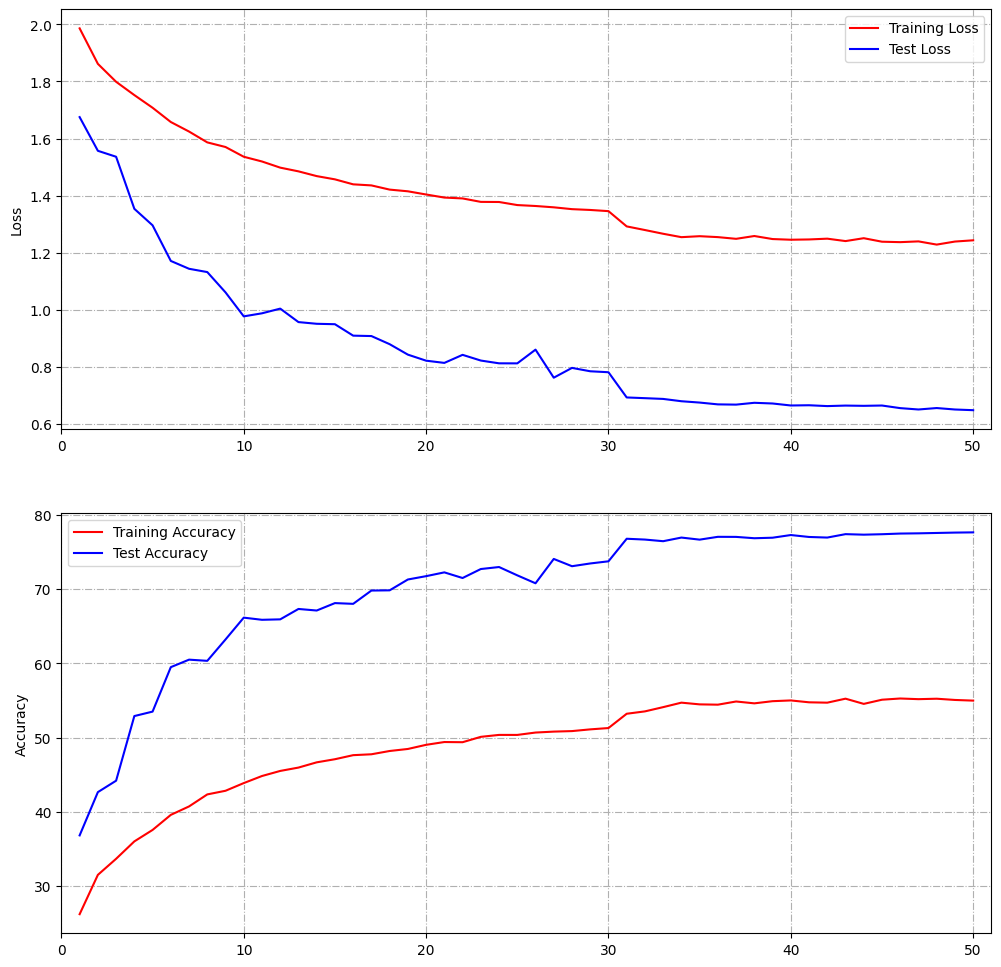

In [23]:
## use function from utils.py
plot_accuracy_losses(train_losses, train_acc, test_losses, test_acc, best_epoch)

## Error analysis

total wrong predictions: 2236


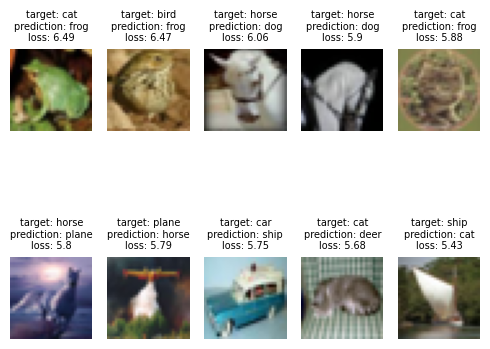

In [24]:
incr_groups_df = plot_top_loss(model, device, test_loader, criterion,
                               label_names = class_labels, img_rows=2, img_cols = 5)

In [25]:
incr_groups_df.loc[incr_groups_df.image > 1]

,target,prediction,loss,image
36,dog,cat,1.488256,168
19,cat,dog,1.292614,128
2,bird,deer,1.886753,113
4,bird,frog,1.801354,84
68,plane,ship,1.477642,82
...,...,...,...,...
12,car,horse,1.661982,2
9,car,cat,2.764147,2
84,truck,frog,3.230475,2
44,frog,car,3.889194,2
